# [IAPR][iapr]: Lab 2 ‒  Object description


**Group ID:** 19

**Author 1 (sciper):** Thomas Berger (287838)  
**Author 2 (sciper):** Pierre Chassagne (289475)   
**Author 3 (sciper):** Thomas Peeters (288239)   

**Release date:** 26.03.2021  
**Due date:** 23.04.2021 


## Important notes

The lab assignments are designed to teach practical implementation of the topics presented during class well as preparation for the final project, which is a practical project which ties together the topics of the course. 

As such, in the lab assignments/final project, unless otherwise specified, you may, if you choose, use external functions from image processing/ML libraries like opencv and sklearn as long as there is sufficient explanation in the lab report. For example, you do not need to implement your own edge detector, etc.

**! Before handling back the notebook !** rerun the notebook from scratch `Kernel` > `Restart & Run All`


[iapr]: https://github.com/LTS5/iapr

## 0. Extract relevant data
We first need to extract the `lab-02-data.tar.gz` archive.
To this end, we use the [tarfile] module from the Python standard library.

[tarfile]: https://docs.python.org/3.6/library/tarfile.html

In [1]:
import tarfile
import os

data_base_path = os.path.join(os.pardir, 'data')
data_folder = 'lab-02-data'
data_part1 = os.path.join(data_base_path, data_folder, 'part1')
data_part2 = os.path.join(data_base_path, data_folder, 'part2')

tar_path = os.path.join(data_base_path, data_folder + '.tar.gz')
with tarfile.open(tar_path, mode='r:gz') as tar:
    tar.extractall(path=data_base_path)

---
## Part 1
In the `lab-02-data/part1` folder, you will find 28x28 grey-scale pictures of handwritten "0" and "1".
These digits have been extracted from MNIST dataset (http://yann.lecun.com/exdb/mnist/).

Your goal is to extract, from each of those images, a 2-dimensional feature vector (i.e. 2 features) and to plot them all on a 2D graph.
If you have chosen good features, the vectors of the "0"'s should nicely cluster in one part of the plane and those of the "1"'s in another.

Please try:
1. Fourier Descriptors (15pts). 
    1. Implementation (10 pts).
    2. Showing invariance to rotation, translation and scaling (5 pts).
2. Additional method of your choice (5 pts)


**Note:** for the Fourier descriptors, the u_k signal has to be constructed by following the contour point after point. Some pre-processing (image binarization, possibly some Mathematical Morphology) might be useful.

### 1.1 Data visualization

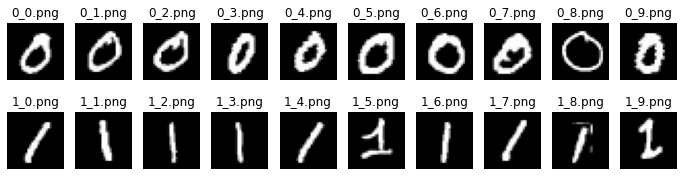

In [2]:
import skimage.io
import matplotlib.pyplot as plt
%matplotlib inline

def load(path, digit='0'):
    digit_path = os.path.join(path, digit)
    digit_names = [nm for nm in os.listdir(digit_path) if '.png' in nm]  # make sure to only load .png
    digit_names.sort()  # sort file names
    ic = skimage.io.imread_collection([os.path.join(digit_path, nm) for nm in digit_names])
    digit_im = skimage.io.concatenate_images(ic)
    return digit_im, digit_names
                        
#  Load zeros and ones
zeros_im, zeros_names = load(data_part1, digit='0')
ones_im, ones_names = load(data_part1, digit='1')


# Plot images
fig, axes = plt.subplots(2, len(zeros_im), figsize=(12, 3))
for ax, im, nm in zip(axes[0], zeros_im, zeros_names):
    ax.imshow(im, cmap='gray')
    ax.axis('off')
    ax.set_title(nm)
for ax, im, nm in zip(axes[1], ones_im, ones_names):
    ax.imshow(im, cmap='gray')
    ax.axis('off')
    ax.set_title(nm)

### 1.2 Fourier descriptors (15 pts)

#### 1.2.1 Implementation

First, we compute the contours of each number using the function `skimage.measure.find_contours`; while this function does not use the sharp transitions of intensity in the image to detect an edge, we found the gray-level contour finding to outperform a more standard edge-detection algorithm like the Laplacian of Gaussian for this specific image.This method give all the contours at a specific gray-level and we take the longest, since it will represent the number.

Then, we compute the fourrier descriptors we are interested in using the formula seen in class.


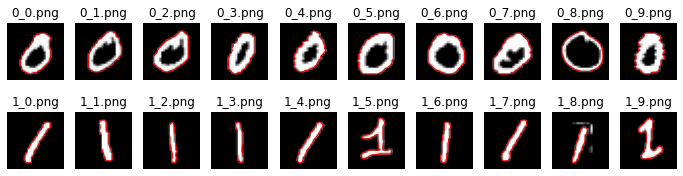

In [3]:
# Add your implementation and discussion
from skimage import measure
import numpy as np
import math
import cmath

zeros_contours = []
ones_contours = []
low = 100

for i in range(0,len(zeros_im)):
    contours = measure.find_contours(zeros_im[i,:,:], low)
    zeros_contours.append(contours[np.argmax([len(c) for c in contours])])
for i in range(0,len(ones_im)):
    contours = measure.find_contours(ones_im[i,:,:], low)
    ones_contours.append(contours[np.argmax([len(c) for c in contours])])

fig, axes = plt.subplots(2, len(zeros_im), figsize=(12, 3))
for ax, im, nm, contour in zip(axes[0], zeros_im, zeros_names, zeros_contours):
    ax.imshow(im, cmap='gray')
    ax.plot(contour[:,1], contour[:,0], linewidth=1,c='r')
    ax.axis('off')
    ax.set_title(nm)
for ax, im, nm, contour in zip(axes[1], ones_im, ones_names, ones_contours):
    ax.imshow(im, cmap='gray')
    ax.plot(contour[:,1], contour[:,0], linewidth=1,c='r')
    ax.axis('off')
    ax.set_title(nm)

In [4]:
def compute_fourrier_descriptor(contour_pts, fourrier_component = [0,1]):
    fourrier_descriptors = []
    #As we need only few fourrier component we do it component wise 
    for i in fourrier_component:
        # For each contour point we add add contribtuion
        fourrier_desc = complex(0,0)
        for j in range(0,len(contour_pts)):
            fourrier_desc += complex(contour_pts[j,0],contour_pts[j,1]) * cmath.exp(- complex(0,1) * 2 * math.pi * j*i/len(contour_pts))
        
        # Transform the number to polar mapping to extract only amplitude (invariant to amplitude and starting point)
        fourrier_desc = cmath.polar(fourrier_desc)
        fourrier_descriptors.append(fourrier_desc[0])

    
    return fourrier_descriptors



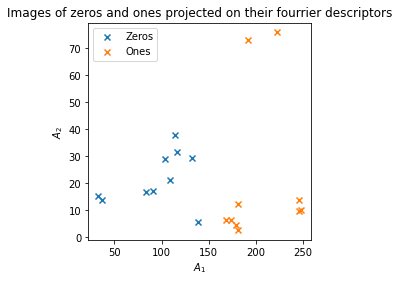

In [5]:
fourrier_comp = [1,2]
zeros_components = np.zeros(shape=(len(zeros_im),2))
for i in range(0,len(zeros_im)):
    # We want a1, a2 ,a3 (not a0 to be invariant to translation)
    fourrier_descriptors = compute_fourrier_descriptor(zeros_contours[i],fourrier_comp)
    
    zeros_components[i] = np.array([fourrier_descriptors[0], fourrier_descriptors[1]])
    
ones_components = np.zeros(shape=(len(ones_im),2))
for i in range(0,len(ones_im)):
    # We want a1, a2 ,a3 (not a0 to be invariant in translation)
    fourrier_descriptors = compute_fourrier_descriptor(ones_contours[i],fourrier_comp)
    
    ones_components[i] = np.array([fourrier_descriptors[0], fourrier_descriptors[1]])

# Plotting
fig, ax = plt.subplots(1, 1, figsize=(4, 4))
plt.scatter(zeros_components[:,0],zeros_components[:,1], marker= 'x',label='Zeros')
plt.scatter(ones_components[:,0],ones_components[:,1], marker= 'x', label='Ones')
plt.title("Images of zeros and ones projected on their fourrier descriptors" )
plt.xlabel(r'${A_%d}$ ' % (fourrier_comp[0]))
plt.ylabel(r'${A_%d}$ ' % (fourrier_comp[1]))
plt.legend()

Using the figure above one can easily separate the ones and the zeros using only the first fourrier descriptors. We decided to not use A0 as we need to be invariant in translation, we used the amplitude of the fourrier descriptors to be invariant in rotation and to the startign point of the contour. Finally we did not use a ratio of fourier descriptors(i.e. A2/A1, ...) as we did not need to be invariant in scaling and this method was giving the best result with zeros and ones.

#### 1.2.2 Invariance

To show invariance, we transformed directly the zeros contours to have a perfect modification. We transformed the images for illustration purpose only and not recomputing contours ont them as it will introduce smalla variations. We showed invarianc to translation, rotation, and scale.

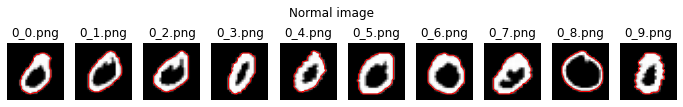

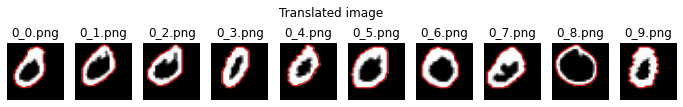

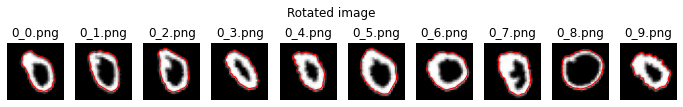

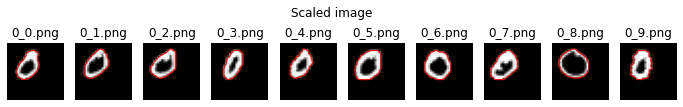

In [6]:
import skimage.util
import skimage.transform

# Prepare data
Translated_zeros = np.zeros([len(zeros_im),28,28])
Rotated_zeros = np.zeros([len(zeros_im),28,28])
Rescaled_zeros = np.zeros([len(zeros_im),28,28])

modified_names = []
modified_names.append(zeros_names[0])
modified_names.append('Translating')
modified_names.append('Rotating')
modified_names.append('Rescaling')

Translated_contours=[]
Rotated_contours=[]
Rescaled_contours=[]

# Creating Rotation matrix
angle = (-60)*math.pi/180
R=np.array([[np.cos(angle),-np.sin(angle)],[ np.sin(angle),np.cos(angle)]])

# Transforming all contours (and images for visualization purposes)
for i in range(0,len(zeros_im)):
    # Translating image
    Translated_zeros[i,:,:] = np.roll(np.roll( zeros_im[i],-3, axis=0),-3, axis=1)
    # Translating contours
    Translated_contours.append(zeros_contours[i] + np.array([-3,-3]))
    
    # Rotating image
    Rotated_zeros[i,:,:] = skimage.transform.rotate( zeros_im[i], 60,preserve_range=True)
    # Rotating contours (and translating it as the rotation is made about a corner)
    Rotated_contours.append(np.matmul(zeros_contours[i],R) + np.array([18,-5] ))

    # Rescaling image (and padding to keep same size)
    Rescaled_zeros[i,:,:] = np.pad(skimage.transform.resize( zeros_im[i], (20,20), mode='constant',preserve_range=True),(0,8))
    # Scaling contours
    Rescaled_contours.append(np.multiply(zeros_contours[i],0.714) )

# Plot contours
fig, axes = plt.subplots(1, len(zeros_im), figsize=(12, 3))
plt.suptitle('Normal image', y=0.8)
for ax, im, nm, contour in zip(axes, zeros_im, zeros_names, zeros_contours):
    ax.imshow(im, cmap='gray')
    ax.plot(contour[:,1], contour[:,0], linewidth=1,c='r')
    ax.axis('off')
    ax.set_title(nm)

fig, axes = plt.subplots(1, len(zeros_im), figsize=(12, 3))
plt.suptitle('Translated image', y=0.8)
for ax, im, nm, contour in zip(axes, Translated_zeros, zeros_names, Translated_contours):
    ax.imshow(im, cmap='gray')
    ax.plot(contour[:,1], contour[:,0], linewidth=1,c='r')
    ax.axis('off')
    ax.set_title(nm)
    
fig, axes = plt.subplots(1, len(zeros_im), figsize=(12, 3))
plt.suptitle('Rotated image', y=0.8)
for ax, im, nm, contour in zip(axes, Rotated_zeros, zeros_names, Rotated_contours):
    ax.imshow(im, cmap='gray')
    ax.plot(contour[:,1], contour[:,0], linewidth=1,c='r')
    ax.axis('off')
    ax.set_title(nm)
    
fig, axes = plt.subplots(1, len(zeros_im), figsize=(12, 3))
plt.suptitle('Scaled image', y=0.8)
for ax, im, nm, contour in zip(axes, Rescaled_zeros, zeros_names, Rescaled_contours):
    ax.imshow(im, cmap='gray')
    ax.plot(contour[:,1], contour[:,0], linewidth=1,c='r')
    ax.axis('off')
    ax.set_title(nm)

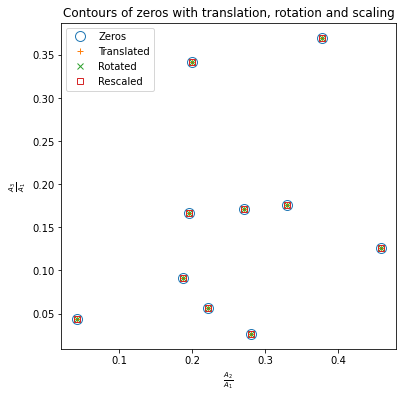

In [7]:
fourrier_components = np.zeros(shape=(len(zeros_im),2))
Translated_components = np.zeros(shape=(len(zeros_im),2))
Rotated_components = np.zeros(shape=(len(zeros_im),2))
Rescaled_components = np.zeros(shape=(len(zeros_im),2))

fourrier_comp = [1,2,3]
for i in range(0,len(zeros_im)):
    # We want a1, a2 ,a3 (not a0 to be invariant to translation)
    # Take a ratio of component (invariant to scaling)
    fourrier_descriptors = compute_fourrier_descriptor(zeros_contours[i],fourrier_comp)
    fourrier_components[i] = np.array([fourrier_descriptors[1]/fourrier_descriptors[0], fourrier_descriptors[2]/fourrier_descriptors[0]])
    
    fourrier_descriptors = compute_fourrier_descriptor(Translated_contours[i],fourrier_comp)
    Translated_components[i] = np.array([fourrier_descriptors[1]/fourrier_descriptors[0], fourrier_descriptors[2]/fourrier_descriptors[0]])
    
    fourrier_descriptors = compute_fourrier_descriptor(Rotated_contours[i],fourrier_comp)
    Rotated_components[i] = np.array([fourrier_descriptors[1]/fourrier_descriptors[0], fourrier_descriptors[2]/fourrier_descriptors[0]])
    
    fourrier_descriptors = compute_fourrier_descriptor(Rescaled_contours[i],fourrier_comp)
    Rescaled_components[i] = np.array([fourrier_descriptors[1]/fourrier_descriptors[0], fourrier_descriptors[2]/fourrier_descriptors[0]])
    
# Plotting fourrier components
fig, ax = plt.subplots(1, 1, figsize=(6,6))

plt.plot(fourrier_components[:,0],fourrier_components[:,1], 'o',ms=10, mfc='none', label='Zeros')
plt.plot(Translated_components[:,0],Translated_components[:,1], '+',label='Translated')
plt.plot(Rotated_components[:,0],Rotated_components[:,1], 'x',label='Rotated')
plt.plot(Rescaled_components[:,0],Rescaled_components[:,1], 's', mfc='none',label='Rescaled')

plt.title("Contours of zeros with translation, rotation and scaling" )
plt.xlabel(r'$\frac{A_%d}{A_%d}$ ' % (fourrier_comp[1],fourrier_comp[0]))
plt.ylabel(r'$\frac{A_%d}{A_%d}$ ' % (fourrier_comp[2],fourrier_comp[0]))
plt.legend()

As one can easily observe on the above figure, transformed contours line up exactly with the non transformed ones. As before we did not take A0 to be invariant in translation. We extract only the amplitude of the fourrier descriptor to be invariant in rotation and to the starting point of the contour. Finally, we took the ratio of fourrier descriptors A2/A1 and A2/A1 to show invariance to scaling.

### 1.3 Additional method (5 pts)

We chose to use the compacity with the A1 formula for the area and the P1 formula for the perimeter.

In order to use it we first have to get the all of the shape of the zeros and ones, here we decided to use the polygon function from skimage which gives the coordinates of the pixels inside a polygon, however one could simply have used a threshold especially since the images are black and white.

We also chose to fill entirely the zeros instead of taking only the contour without the hole in it, indeed this is much simpler to do so and zeros are still recognisable even filled, and hence they also have a much lower compacity.

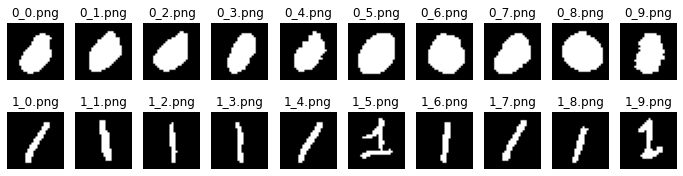

In [8]:
from skimage.draw import polygon

zeros_shapes = np.zeros((10,28, 28), 'uint8')
ones_shapes = np.zeros((10,28, 28), 'uint8')

for i in range(len(zeros_im)):
    # Extract the shapes of the zeros to fill them with white
    rr_z, cc_z = polygon(zeros_contours[i][:,0], zeros_contours[i][:,1], zeros_shapes[i].shape)
    zeros_shapes[i,rr_z,cc_z] = 255
    
    # Exctract the shapes of the ones to fill it with white
    rr_o, cc_o = polygon(ones_contours[i][:,0], ones_contours[i][:,1], ones_shapes[i].shape)
    ones_shapes[i,rr_o,cc_o] = 255

fig, axes = plt.subplots(2, len(zeros_im), figsize=(12, 3))
for ax, im, nm in zip(axes[0], zeros_shapes, zeros_names):
    ax.imshow(im, cmap='gray')
    ax.axis('off')
    ax.set_title(nm)
for ax, im, nm in zip(axes[1], ones_shapes, ones_names):
    ax.imshow(im, cmap='gray')
    ax.axis('off')
    ax.set_title(nm)

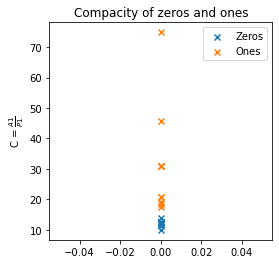

In [9]:
from PIL import Image

C_z = np.zeros(10)
C_o = np.zeros(10)

for i in range(len(zeros_im)):
    C_z[i] = len(zeros_contours[i])**2/(len(zeros_shapes[zeros_shapes == 255])*0.2)
    C_o[i] = len(ones_contours[i])**2/(len(ones_shapes[ones_shapes == 255])*0.2)

# Plotting
fig, ax = plt.subplots(1, 1, figsize=(4, 4))
plt.scatter(np.zeros(10),C_z[:], marker= 'x',label='Zeros')
plt.scatter(np.zeros(10),C_o[:], marker= 'x', label='Ones')
plt.title("Compacity of zeros and ones" )
plt.ylabel(r'C = $\frac{A1}{P1}$')
plt.legend()

The results obtained show that one can perfectly separate the ones and zeros by using the compacity. We can also see that sometimes the compaciity of zeros are under 4*pi this mainly due to approximation because we are using pixels.

---
## Part 2
The `lab-02-data/part2` folder contains grey-scale pictures of handwritten "2" and "3".
Extract the same feature (typically 2 Fourier descriptors) as in part 1 also on these images and plot them on the same graph as the features of the "0" and "1".
Is it possible to discriminate all these 4 digits with a 2-dimensional feature vector?

### 2.1 Data visualization

#### Pre-processing : 

For each images we first add a gaussian_filter (blur the image) and a binary treshold to smooth the countours of our shapes (number). For each number we can choose different values for the variance of the gaussian blur and for the treshold of the binarisation. Using this pre-processing method improve a bit the results but we can obtain good separation between the 0 1 and 3 even without that. 

We observed for the number 2 that we have some important difference between the images. This is why we add 
some mathematical morphology (dilatation and erosion) to get shapes closer to each other. Using this pre-processing method improve the result of the separation between the number 2 and number 3 


In [10]:
# Use for pre-processing : 

def blurr_binary(image,sigma,tresh):

    blur = cv2.GaussianBlur(image, (0,0), sigmaX=sigma, sigmaY=sigma, borderType = cv2.BORDER_DEFAULT)
    n,threshIm = cv2.threshold(blur,tresh, 255, cv2.THRESH_BINARY)

    return threshIm

def closing_opening(image):
    image=skimage.morphology.binary_dilation(image, selem=None, out=None)
    image=skimage.morphology.binary_dilation(image, selem=None, out=None)
    
    image=skimage.morphology.binary_erosion(image, selem=None, out=None)
    image=skimage.morphology.binary_erosion(image, selem=None, out=None)
    
    image = np.multiply(image, 1)*255
    return image

Here we plot the different images before and after pre-processing : 

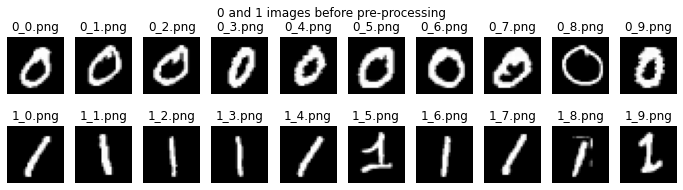

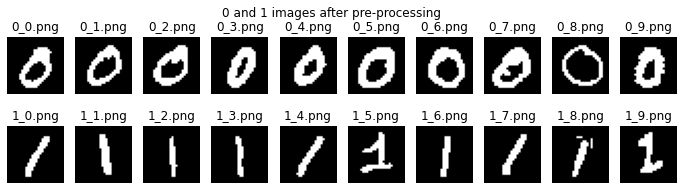

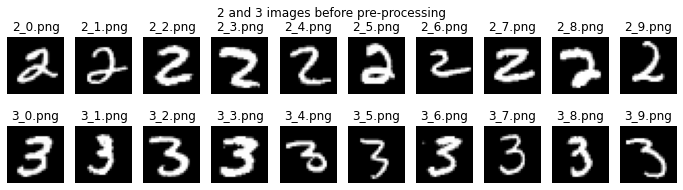

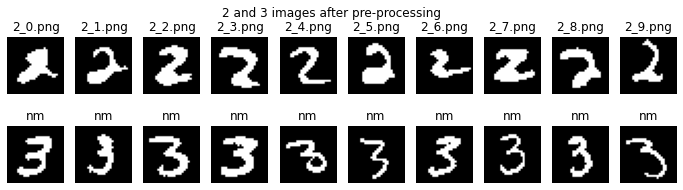

In [11]:
import skimage.io
import matplotlib.pyplot as plt
import cv2
import math
import cmath
import numpy as np

%matplotlib inline

def load(path, digit='0'):
    digit_path = os.path.join(path, digit)
    digit_names = [nm for nm in os.listdir(digit_path) if '.png' in nm]  # make sure to only load .png
    digit_names.sort()  # sort file names
    ic = skimage.io.imread_collection([os.path.join(digit_path, nm) for nm in digit_names])
    digit_im = skimage.io.concatenate_images(ic)
    return digit_im, digit_names
                        
#  Load zeros and ones
zeros_im, zeros_names = load(data_part1, digit='0')
ones_im, ones_names = load(data_part1, digit='1')


# Plot images before pre-processing
fig, axes = plt.subplots(2, len(zeros_im), figsize=(12, 3))
for ax, im, nm in zip(axes[0], zeros_im, zeros_names):
    ax.imshow(im, cmap='gray')
    ax.axis('off')
    ax.set_title(nm)
fig.suptitle('0 and 1 images before pre-processing')
for ax, im, nm in zip(axes[1], ones_im, ones_names):
    ax.imshow(im, cmap='gray')
    ax.axis('off')
    ax.set_title(nm)
    
#blur the image and use image binarization : 
#------------------------------------------------------------------------------
tresh=80
sigma=0.5

for i in range(0,len(zeros_im)):
    zeros_im[i,:,:]= blurr_binary(zeros_im[i,:,:],sigma,tresh) 
for i in range(0,len(ones_im)):
    ones_im[i,:,:]= blurr_binary(ones_im[i,:,:],sigma,tresh)
#------------------------------------------------------------------------------

# Plot images after pre-processing 
fig, axes = plt.subplots(2, len(zeros_im), figsize=(12, 3))
for ax, im, nm in zip(axes[0], zeros_im, zeros_names):
    ax.imshow(im, cmap='gray')
    ax.axis('off')
    ax.set_title(nm)
fig.suptitle('0 and 1 images after pre-processing')
for ax, im, nm in zip(axes[1], ones_im, ones_names):
    ax.imshow(im, cmap='gray')
    ax.axis('off')
    ax.set_title(nm)

    
#  Load twos and threes
from skimage import morphology

twos_im, twos_names = load(data_part2, digit='2')
threes_im, threes_names = load(data_part2, digit='3')

# Plot images before pre-processing 
fig, axes = plt.subplots(2, len(twos_im), figsize=(12, 3))
for ax, im, nm in zip(axes[0], twos_im, twos_names):
    ax.imshow(im, cmap='gray')
    ax.axis('off')
    ax.set_title(nm)
fig.suptitle('2 and 3 images before pre-processing')
for ax, im, nm in zip(axes[1], threes_im, threes_names):
    ax.imshow(im, cmap='gray')
    ax.axis('off')
    ax.set_title(nm)
    
#------------------------------------------------------------------------------
#blur the images, use image binarization and add some morphology transformation (dilation and erosion) for the number 2 images : 
tresh=120
sigma=0.3

for i in range(0,len(twos_im)):
    twos_im[i,:,:]= blurr_binary(twos_im[i,:,:],sigma,tresh)
    twos_im[i,:,:]= closing_opening(twos_im[i,:,:])
for i in range(0,len(threes_im)):
    threes_im[i,:,:]= blurr_binary(threes_im[i,:,:],sigma,tresh)
#------------------------------------------------------------------------------

fig, axes = plt.subplots(2, len(twos_im), figsize=(12, 3))
for ax, im, nm in zip(axes[0], twos_im, twos_names):
    ax.imshow(im, cmap='gray')
    ax.axis('off')
    ax.set_title(nm)
fig.suptitle('2 and 3 images after pre-processing')
for ax, im, nm in zip(axes[1], threes_im, threes_names):
    ax.imshow(im, cmap='gray')
    ax.axis('off')
    ax.set_title('nm')

Here, we observe that after preprocessiong, the number 2 images are more similar. This will allow to improve the separability of the twos with the other numbers. However pre-processing alterate sometimes the numbers and one should be careful, for exemple the fifth two here looks more like a 6 and therefore could be a problem if we would like to separate the 6 and the 2.   

### 2.2 Fourier descriptors - 4 digits (10 pts)

Here we compute the contours on each images using the $\textit{function measure.find_contours()}$ from the skimage library. We then plot the contours on each images. 

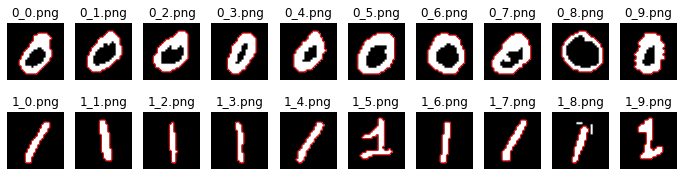

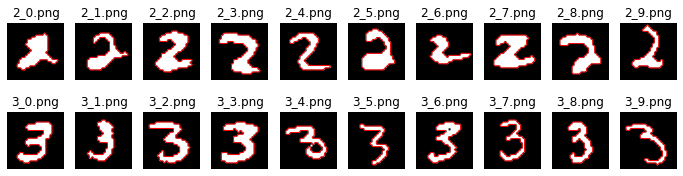

In [12]:

from skimage import measure
import numpy as np
import cmath

zeros_contours = []
ones_contours = []
low = 100 # Value along which to find contours in the array.

# compute the contours for the 0 and 1 : 
for i in range(0,len(zeros_im)):
    contours = measure.find_contours(zeros_im[i,:,:], low)
    zeros_contours.append(contours[np.argmax([len(c) for c in contours])])
for i in range(0,len(ones_im)):
    contours = measure.find_contours(ones_im[i,:,:], low)
    ones_contours.append(contours[np.argmax([len(c) for c in contours])])

# plot the contours for the 0 and 1 : 
fig, axes = plt.subplots(2, len(zeros_im), figsize=(12, 3))
for ax, im, nm, contour in zip(axes[0], zeros_im, zeros_names, zeros_contours):
    ax.imshow(im, cmap='gray')
    ax.plot(contour[:,1], contour[:,0], linewidth=1,c='r')
    ax.axis('off')
    ax.set_title(nm)
for ax, im, nm, contour in zip(axes[1], ones_im, ones_names, ones_contours):
    ax.imshow(im, cmap='gray')
    ax.plot(contour[:,1], contour[:,0], linewidth=1,c='r')
    ax.axis('off')
    ax.set_title(nm)
    

twos_contours = []
threes_contours = []
low = 100

# compute the contours for the 2 and 3 : 
for i in range(0,len(twos_im)):
    contours = measure.find_contours(twos_im[i,:,:], low)
    twos_contours.append(contours[np.argmax([len(c) for c in contours])])
for i in range(0,len(threes_im)):
    contours = measure.find_contours(threes_im[i,:,:], low)
    threes_contours.append(contours[np.argmax([len(c) for c in contours])])

# plot the contours for the 2 and 3 : 
fig, axes = plt.subplots(2, len(twos_im), figsize=(12, 3))
for ax, im, nm, contour in zip(axes[0], twos_im, twos_names, twos_contours):
    ax.imshow(im, cmap='gray')
    ax.plot(contour[:,1], contour[:,0], linewidth=1,c='r')
    ax.axis('off')
    ax.set_title(nm)
for ax, im, nm, contour in zip(axes[1], threes_im, threes_names, threes_contours):
    ax.imshow(im, cmap='gray')
    ax.plot(contour[:,1], contour[:,0], linewidth=1,c='r')
    ax.axis('off')
    ax.set_title(nm)
    
    

Here is a function to plot on a 2-D axis the two fourrier descriptors of the different numbers. The function take two inputs : 

fourrier_comp : array : give the fourrier descriptor that we want to compute. The two first fourrier components are ploted on the figure. 

scale : Select if we want to plot a ratio (A2/A1) or just the amplitude (A2). In the case of the ratio, we divide each fourrier descriptor by the first fourrier_descriptor(fourrier_descriptor[fourrier_comp[0]])

The functions give as output : a 2D array N*D with N the number of contours (in our case 40) and D the number of fourrier descriptor computed. 





In [13]:
def plot_result(fourrier_comp,scale):
    if scale :
        zeros_components = np.zeros(shape=(len(zeros_im),len(fourrier_comp)-1))
        ones_components = np.zeros(shape=(len(ones_im),len(fourrier_comp)-1))
        twos_components = np.zeros(shape=(len(twos_im),len(fourrier_comp)-1)) 
        threes_components = np.zeros(shape=(len(threes_im),len(fourrier_comp)-1))
    else : 
        zeros_components = np.zeros(shape=(len(zeros_im),len(fourrier_comp)))
        ones_components = np.zeros(shape=(len(ones_im),len(fourrier_comp)))
        twos_components = np.zeros(shape=(len(twos_im),len(fourrier_comp))) 
        threes_components = np.zeros(shape=(len(threes_im),len(fourrier_comp)))
        
    for i in range(0,len(zeros_im)):
    # We want a1, a2 ,a3 (not a0 to be invariant to translation)
        fourrier_descriptors = compute_fourrier_descriptor(zeros_contours[i],fourrier_comp)
        fourrier_array=[]
        if scale : 
            for j in range(1,len(fourrier_comp)) : 
                fourrier_array.append(fourrier_descriptors[j]/fourrier_descriptors[0])    
        else :
            for j in range(0,len(fourrier_comp)) : 
                fourrier_array.append(fourrier_descriptors[j])
        zeros_components[i] = fourrier_array
    
    
    for i in range(0,len(ones_im)):
    # We want a1, a2 ,a3 (not a0 to be invariant to translation)
        fourrier_descriptors = compute_fourrier_descriptor(ones_contours[i],fourrier_comp)
    # Take a ratio of component (invariant to scaling)
        fourrier_array=[]
        if scale : 
            for j in range(1,len(fourrier_comp)) : 
                fourrier_array.append(fourrier_descriptors[j]/fourrier_descriptors[0])    
        else :
            for j in range(0,len(fourrier_comp)) : 
                fourrier_array.append(fourrier_descriptors[j])
        ones_components[i] = fourrier_array
    
   
    for i in range(0,len(twos_im)):
        # We want a1, a2 ,a3 (not a0 to be invariant to translation)
        fourrier_descriptors = compute_fourrier_descriptor(twos_contours[i],fourrier_comp)
    # Take a ratio of component (invariant to scaling)
        fourrier_array=[]
        if scale : 
            for j in range(1,len(fourrier_comp)) : 
                fourrier_array.append(fourrier_descriptors[j]/fourrier_descriptors[0])  
                
        else :
            for j in range(0,len(fourrier_comp)): 
                fourrier_array.append(fourrier_descriptors[j])
        twos_components[i] = fourrier_array
    
 
    for i in range(0,len(threes_im)):
    # We want a1, a2 ,a3 (not a0 to be invariant in translation)
        fourrier_descriptors = compute_fourrier_descriptor(threes_contours[i],fourrier_comp)
    # Take a ratio of component depending on scaling
        fourrier_array=[]
        if scale : 
            for j in range(1,len(fourrier_comp)) : 
                fourrier_array.append(fourrier_descriptors[j]/fourrier_descriptors[0]) 
                
        else :
            for j in range(0,len(fourrier_comp)) : 
                fourrier_array.append(fourrier_descriptors[j])
        
        threes_components[i] = fourrier_array
    
    # Plotting
    fig, ax = plt.subplots(1, 1, figsize=(4, 4))

    plt.scatter(zeros_components[:,0],zeros_components[:,1], marker= 'x',label='zeros')
    plt.scatter(ones_components[:,0],ones_components[:,1], marker= 'x', label='ones')
    plt.scatter(twos_components[:,0],twos_components[:,1], marker= 'x',label='two')
    plt.scatter(threes_components[:,0],threes_components[:,1], marker= 'x', label='three')

    plt.title("Images of zeros ones twos and threes projected on their fourrier descriptors" )
    if scale : 
        plt.xlabel(r'$\frac{A_%d}{A_%d}$ ' % (fourrier_comp[1],fourrier_comp[0]))
        plt.ylabel(r'$\frac{A_%d}{A_%d}$ ' % (fourrier_comp[2],fourrier_comp[0]))
    else :
        plt.xlabel(r'$A_%d$ ' % (fourrier_comp[0]))
        plt.ylabel(r'$A_%d$' % (fourrier_comp[1]))
    plt.legend()
    
    # USE LATER FOR ML : 
    points=np.concatenate((zeros_components,ones_components,twos_components, threes_components), axis=0)
    return points

Here we run our function plot_result. We can try with different fourrier_comp : 

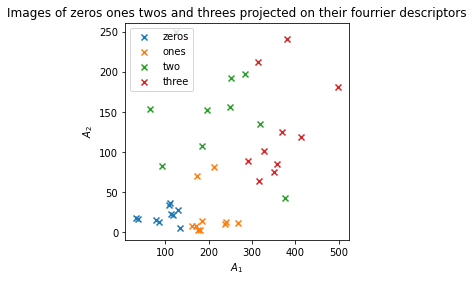

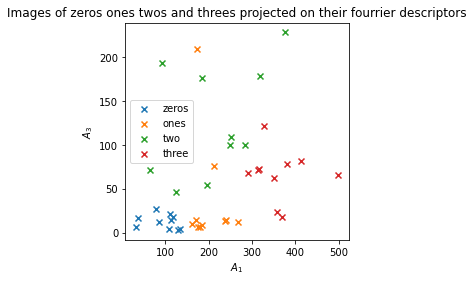

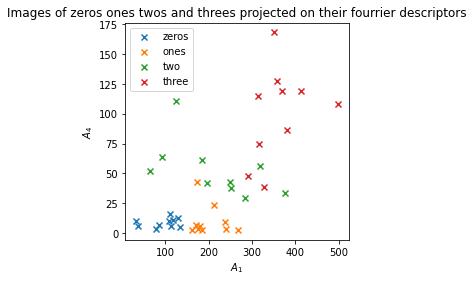

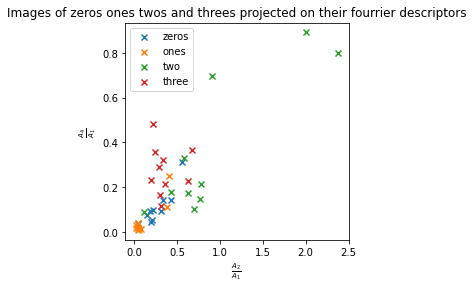

In [14]:
scale= False
fourrier_comp4 = [1,2]
points4=plot_result(fourrier_comp4,scale)

scale= False
fourrier_comp4 = [1,3]
points4=plot_result(fourrier_comp4,scale)

scale= False
fourrier_comp4 = [1,4]
points4=plot_result(fourrier_comp4,scale)

scale= True
fourrier_comp4 = [1,2,4]
points4=plot_result(fourrier_comp4,scale)



On the 4 figures above, we observe the projections of different fourrier descriptor on a 2D graph. Looking at the last figure we observe that if we use ratio of amplitude, we obtain bad results and it is not possible to separate the 4 numbers. 

Looking at the 3 first figures, we observe that if we don't use the ratio of amplitude but only the amplitude of the fourrier descriptor, we can separate the 0, 1 and 3 with only A1. Nevertheless we observe that the twos have a large set of value on A1. Therefore, we can try to find a second fourrier descriptor that improve the separability of the twos with the other numbers. We obtain the best result using A4 as the second fourrier descriptor. Nevertheless, we observe that this is still not enough to completely separate the four numbers into four cluster. 

 

##### Using a larger set of fourrier descriptor 

Here we will try to separate the four number using a larger set of fourrier descriptor. We will use the K-Means algorithm to separate the points in 4 clusters. 

clustering : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 1 1 2 2 2 2 0 0 0 2 2 0 0 3 0 3 3 3 3 0
 3 0 3]


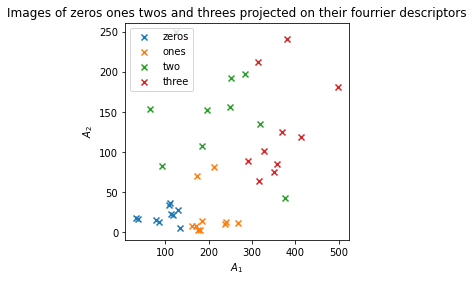

In [15]:
scale= False
fourrier_comp5 = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20]
points5=plot_result(fourrier_comp5,scale)


from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=4, random_state=0).fit(points5)
print('clustering :',kmeans.labels_)


On the array above, we observe that even with a larger number of fourrier descriptor, it is not possible to separate them using unseprvised clustering. We could probably separate them using classification but we need more data to be able to create such a classification model. 

### Function used  :

###### CV2 library  :  
It is a library used for real time computer vision. In our case we use it for pre-processing on our images : 

cv2.GaussianBlur : It create a gaussian filter on the input to smooth the image. We put as input the kernel standard deviation along the X and Y axis. In our case we decided to have the same values in the X and Y axis. 

cv2.threshold : Use for tresholding the image. We put as input the greyscale image and the value of the treshold. all the pixels below this value are put the 0 and all the pixels above are put equal to 255. 

###### skimage library :
It is an open-source image processing library. In our case, we use it for pre-processing. 
https://scikit-image.org/docs/dev/api/skimage.morphology.html

skimage.morphology.binary_dilation : create a dilation of a greyscale image (Dilation enlarges bright regions and shrinks dark regions)

skimage.morphology.binary_erosion : create an erosion of a greyscale image (Erosion shrinks bright regions and enlarges dark regions)

https://scikit-image.org/docs/0.8.0/api/skimage.measure.find_contours.html
skimage.measure.find_contours : Find contours in a 2D array. We put as input the 2D array and a level value (Value along which to find contours in the array). 

##### sklearn : 
Library used for machine learning. In our case we use sklear for K-Mean algorithm (clustering)

sklearn.cluster.Means : Compute the K-mean algorithm. We put as input the number of cluster and the points we want to cluster. 